# Importing the important libraries and dataset

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder

# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\selin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\selin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\selin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [133]:
data = pd.read_csv("spam.csv",encoding='latin1')


### Step 1 Data Cleaning

#### `data.sample(5)` will randomly pick 5 emails from the dataset

In [134]:
data.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
4252,ham,Juz now havent woke up so a bit blur blur... C...,NaN,NaN,NaN
3646,ham,"Hey babe, my friend had to cancel, still up fo...",NaN,NaN,NaN
4355,ham,Great. So should i send you my account number.,NaN,NaN,NaN
2697,ham,Can you use foreign stamps for whatever you se...,NaN,NaN,NaN
1099,ham,Been up to ne thing interesting. Did you have ...,NaN,NaN,NaN


In [135]:
data.shape

(5572, 5)

#### Remove unnecessary columns named “Unnamed: 2,” “Unnamed: 3,” and “Unnamed: 4.”

In [136]:
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

#### Rename two columns to make them more understandable: “v1” becomes “result,” and “v2” becomes "emails"

In [137]:
data.rename(columns={'v1': 'result', 'v2': 'emails'}, inplace=True)

#### First five dataset to show the changes

In [138]:
data.head(5)

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Check and remove missing or duplicate entries


In [139]:
data.isnull().sum()

result    0
emails    0
dtype: int64

In [140]:
data.duplicated().sum()

np.int64(403)

In [141]:
data = data.drop_duplicates(keep='first')
data.shape

(5169, 2)

In [142]:
data.head()

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Data Cleaning is done upuntil now

## Step 2 Exploratory Data Analysis

### Pie chart to show the distribution of spam and ham in the data

In [143]:
data['result'].value_counts()

result
ham     4516
spam     653
Name: count, dtype: int64

#### When you use .index, you get the labels

In [144]:
data['result'].value_counts().index

Index(['ham', 'spam'], dtype='object', name='result')

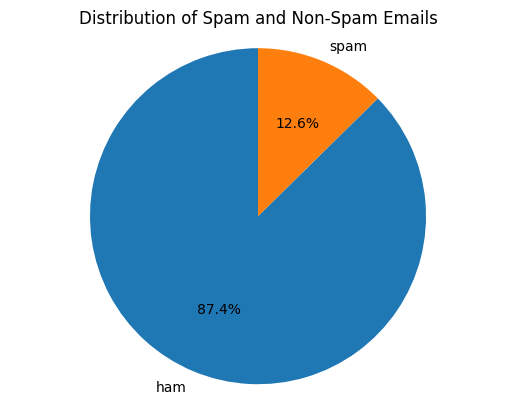

In [145]:
plt.Figure(figsize=(9,9))
plt.pie(data['result'].value_counts(),
        labels=data['result'].value_counts().index,
        autopct='%1.1f%%',
        startangle=90)
plt.title('Distribution of Spam and Non-Spam Emails')
plt.axis('equal') 
plt.show()

##### autopct='%1.1f%%'
##### This tells Matplotlib to display percent values on each slice.%1.1f%% means:1 digit before the decimal,1 digit after the decimal.The double % is how you print a literal % sign

##  Average Length of Emails for Spam and Ham

In [146]:
data['length']=data['emails'].apply(len)
data['num_words']=data['emails'].apply(word_tokenize).apply(len)
data['num_sentences'] = data['emails'].apply(sent_tokenize).apply(len)
data.head(2)

,result,emails,length,num_words,num_sentences
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2


#### word_tokenize: This function (from the nltk.tokenize module) splits a sentence into individual words. 
#### sent_tokenize: This function (from nltk.tokenize) breaks the text into sentences.

In [147]:
avg_length_spam=data[data['result']=='spam']['length'].mean()
avg_length_ham=data[data['result']=='ham']['length'].mean()
print("Average Length of Spam Emails:", avg_length_spam)
print("Average Length of Ham Emails:", avg_length_ham)


Average Length of Spam Emails: 137.89127105666157
Average Length of Ham Emails: 70.45925597874225


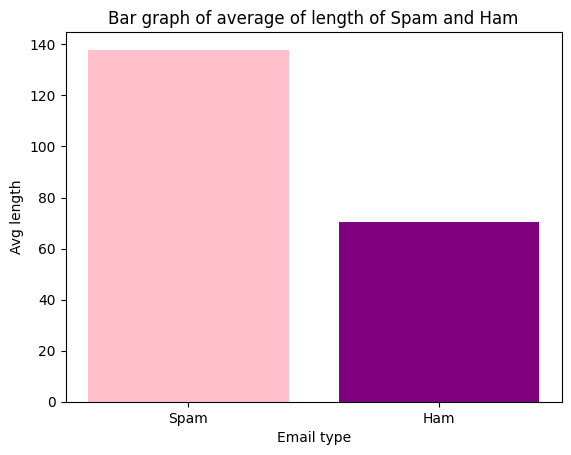

In [148]:
plt.bar(['Spam','Ham'],[avg_length_spam,avg_length_ham],color=['pink','purple'])
plt.title('Bar graph of average of length of Spam and Ham')
plt.xlabel('Email type')
plt.ylabel('Avg length')
plt.show()

#### The graph shows that spams have longer sentences than hams

### Relationship between Length and Spam

Correlation coefficient between email length and spam classification: 0.38471706671430644


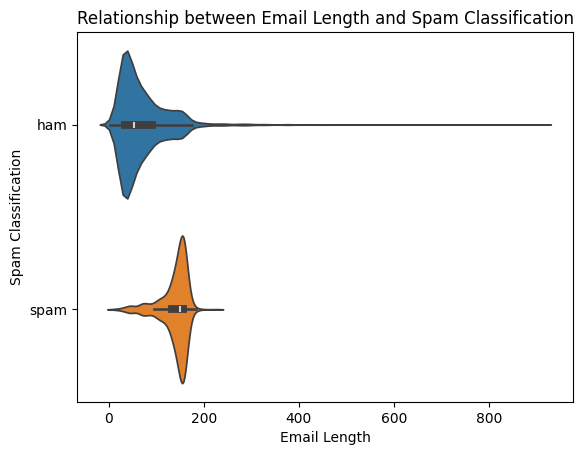

In [149]:
correlation = data['length'].corr((data['result'] == 'spam').astype(int))
print("Correlation coefficient between email length and spam classification:", correlation)


sns.violinplot(data=data, x='length', y='result', hue='result')
plt.xlabel('Email Length')
plt.ylabel('Spam Classification')
plt.title('Relationship between Email Length and Spam Classification')
plt.show()

### Another way to find the correlation between string and integer

In [150]:
data['result_encoded'] = data['result'].map({'ham': 0, 'spam': 1})

# Now compute correlation
corr = data['result_encoded'].corr(data['length'])
print(corr)

0.38471706671430644


In [151]:
correlation_matrix=data[['length','num_words','num_sentences']].corr()
print("The Relationship between Features are ",correlation_matrix )

The Relationship between Features are                   length  num_words  num_sentences
length         1.000000   0.965760       0.624139
num_words      0.965760   1.000000       0.679971
num_sentences  0.624139   0.679971       1.000000


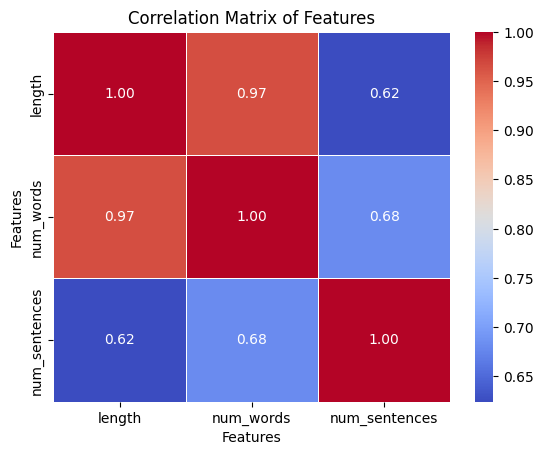

In [152]:
# Visualize the relationship between features using heatmap
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm',fmt=".2f",linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [153]:
data.head()

,result,emails,length,num_words,num_sentences,result_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,0
1,ham,Ok lar... Joking wif u oni...,29,8,2,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,1
3,ham,U dun say so early hor... U c already then say...,49,13,1,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0


### Data Processing

In [154]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\selin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [155]:
#ps=PorterStemmer() //stemming

lemmatizer=WordNetLemmatizer()
stop_words=set(stopwords.words('english'))
#pos stands for part of speech ,
# If you don't give a POS, it defaults to noun, which may not always give correct base forms.
# Function to get POS tag for lemmatization (simplified)
def get_pos(word):
    return 'v'  # Defaulting to verb for simplicity

#Preprocessing function
def preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    clean_tokens = []
    for word in tokens:
        word = re.sub(r'[^a-zA-Z0-9]', '', word)
        if word and word not in stop_words:
            lemma = lemmatizer.lemmatize(word, pos=get_pos(word))
            clean_tokens.append(lemma)
    return ' '.join(clean_tokens)

# Apply preprocessing
data['transform_text'] = data['emails'].apply(preprocess)
# Show result
#print(data[['emails', 'transform_text']].head())


#data['transform_text'] = data['emails'].str.lower()
# Tokenization
#data['transform_text'] = data['transform_text'].apply(word_tokenize)

# Removing special characters
#data['transform_text'] = data['transform_text'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in x])

# Removing stop words and punctuation
#stop_words = set(stopwords.words('english'))
#data['transform_text'] = data['transform_text'].apply(lambda x: [word for word in x if word not in stop_words and word not in string.punctuation])

# Stemming
#ps = PorterStemmer()
#data['transform_text'] = data['transform_text'].apply(lambda x: [ps.stem(word) for word in x])

# Convert the preprocessed text back to string
#data['transform_text'] = data['transform_text'].apply(lambda x: ' '.join(x))

# Display the preprocessed data
#print(data[['emails', 'transform_text']].head())

#### The transformed_text is the final cleaned data for the ml model

In [156]:
data.head()

,result,emails,length,num_words,num_sentences,result_encoded,transform_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,0,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,8,2,0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,49,13,1,0,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0,nah nt think go usf live around though


### Time for preparing data for ML:Label Encoding and Vectorization